Nb features AVANT sélection : 40
Distribution des classes (train complet) :
target_is_fraud
0    155076
1      4924
Name: count, dtype: int64
  → Ratio fraude : 3.08%

Taille X_train : (128000, 40)  |  X_val : (32000, 40)
Fraudes dans y_train : 3939 (3.08%)
Fraudes dans y_val   : 985 (3.08%)

Calcul de l'importance des features...
Top 20 features les plus importantes :
                feature  importance
              ip_risk_z    0.116953
         device_trust_z    0.066047
        num_devices_30d    0.065755
tx_amount_total_30d_eur    0.054178
      credit_score_norm    0.047704
     avg_amount_30d_eur    0.047415
           credit_score    0.043044
          tenure_months    0.037487
income_estimate_alt_eur    0.034580
             income_log    0.033735
     max_amount_30d_eur    0.032963
      annual_income_eur    0.030118
      internal_signal_7    0.029255
      internal_signal_8    0.028373
      internal_signal_5    0.028173
      internal_signal_2    0.028124
      internal_s

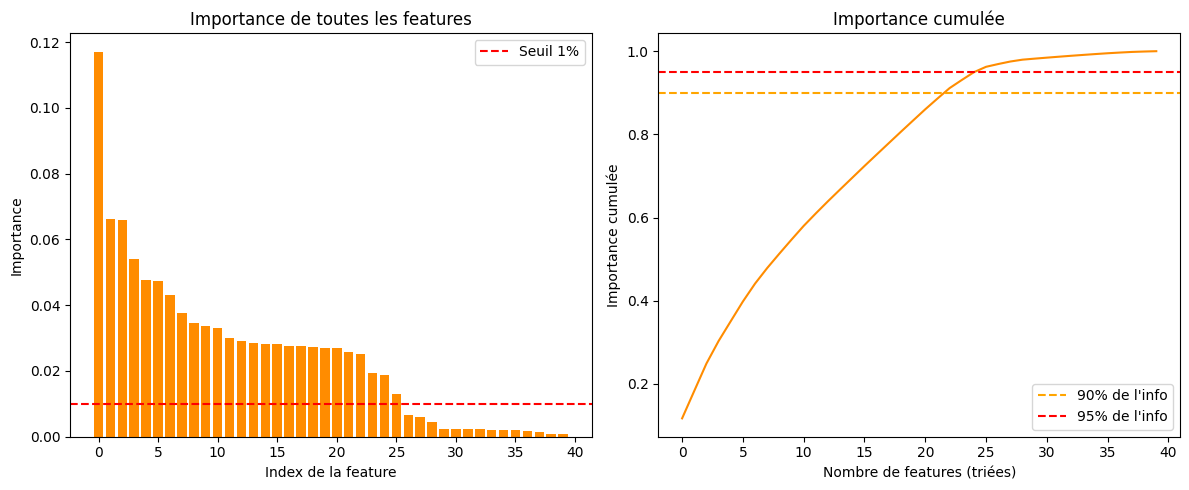


[Graphique sauvegardé → feature_importance_adasyn.png]

Nb features APRÈS sélection : 26

Rééchantillonnage : ADASYN appliqué avec succès.

APRÈS ADASYN :
  Taille X_train : (248278, 26)  (était (128000, 26))
  Distribution :
target_is_fraud
1    124217
0    124061
Name: count, dtype: int64
  → Ratio fraude : 50.03%

  Note : avec ADASYN le ratio n'est pas exactement 50/50
  (contrairement à SMOTE) car la génération est adaptative.

Best params: {'max_depth': 15, 'n_estimators': 300}

Confusion Matrix :
[[27706  3309]
 [  762   223]]

Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     31015
           1       0.06      0.23      0.10       985

    accuracy                           0.87     32000
   macro avg       0.52      0.56      0.52     32000
weighted avg       0.95      0.87      0.91     32000


[Classement des features sauvegardé → feature_importance_ranking_adasyn.csv]


In [2]:
"""
====================================================================
SÉLECTION DE FEATURES + ADASYN (Adaptive Synthetic Sampling)
====================================================================
Objectif : Même pipeline que feature_selection_smote.py, mais on
           remplace SMOTE par ADASYN pour un rééchantillonnage plus
           intelligent et adaptatif.

Pourquoi ADASYN plutôt que SMOTE ?
  - SMOTE : génère le même nombre de points synthétiques partout,
    uniformément entre tous les exemples minoritaires
  - ADASYN : génère PLUS de points synthétiques là où le modèle
    a du mal à classer (zones difficiles / frontières floues)
    → Se concentre sur les cas de fraude les plus "ambigus"
    → Meilleur pour les fraudes avec des patterns complexes

Quand préférer ADASYN ?
  ✓ Quand les fraudes ont des profils très variés (clusters distincts)
  ✓ Quand SMOTE donne un recall fraude insuffisant
  ✗ Évite si le bruit dans tes données est élevé : ADASYN risque de
    sur-amplifier des outliers

RÈGLE CRITIQUE : ADASYN ne s'applique QUE sur X_train / y_train.
  Jamais sur la validation ni le test → sinon fuite de données (data leak)

Pipeline :
  1. Split train / val AVANT tout rééchantillonnage
  2. Calcul de l'importance des features (RF sur données originales)
  3. Sélection des features
  4. Application de ADASYN uniquement sur X_train
  5. GridSearchCV + évaluation sur X_val (données réelles, non augmentées)
====================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import ADASYN

# pip install imbalanced-learn  (si pas encore installé)


# ──────────────────────────────────────────────────────────────────
# 0. CHARGEMENT DES DONNÉES
# ──────────────────────────────────────────────────────────────────

train = pd.read_csv('../6.Data/Yann_Process_train.csv')
test  = pd.read_csv('../6.Data/Yann_Process_test.csv')

target = 'target_is_fraud'
id_col = 'customer_id'

X = train.drop(columns=[target, id_col])
y = train[target]
X_test = test.drop(columns=[id_col])

print(f"Nb features AVANT sélection : {X.shape[1]}")
print(f"Distribution des classes (train complet) :\n{y.value_counts()}")
print(f"  → Ratio fraude : {y.mean()*100:.2f}%\n")


# ──────────────────────────────────────────────────────────────────
# 1. SPLIT TRAIN / VALIDATION
#    À faire EN PREMIER, avant ADASYN et avant la sélection de features,
#    pour s'assurer qu'aucune information du val ne "contamine" le train.
# ──────────────────────────────────────────────────────────────────

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y      # préserve le ratio fraude/non-fraude dans chaque split
)

print(f"Taille X_train : {X_train.shape}  |  X_val : {X_val.shape}")
print(f"Fraudes dans y_train : {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Fraudes dans y_val   : {y_val.sum()} ({y_val.mean()*100:.2f}%)\n")


# ──────────────────────────────────────────────────────────────────
# 2. CALCUL DE L'IMPORTANCE DES FEATURES
#    On utilise X_train ORIGINAL (sans ADASYN) pour scorer les features.
#    Raison : ADASYN crée des points synthétiques dans les zones difficiles
#    → les importances seraient biaisées vers ces zones, pas les vraies données.
# ──────────────────────────────────────────────────────────────────

print("Calcul de l'importance des features...")

selector_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',   # équilibrage léger pour ce RF de sélection seulement
    random_state=42,
    n_jobs=-1
)
selector_rf.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'feature':    X_train.columns,
    'importance': selector_rf.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 20 features les plus importantes :")
print(importance_df.head(20).to_string(index=False))


# ──────────────────────────────────────────────────────────────────
# 3. VISUALISATION DES IMPORTANCES
# ──────────────────────────────────────────────────────────────────

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(importance_df)), importance_df['importance'], color='darkorange')
plt.axhline(y=0.01, color='red', linestyle='--', label='Seuil 1%')
plt.xlabel('Index de la feature')
plt.ylabel('Importance')
plt.title('Importance de toutes les features')
plt.legend()

plt.subplot(1, 2, 2)
cumulative = importance_df['importance'].cumsum()
plt.plot(range(len(importance_df)), cumulative, color='darkorange')
plt.axhline(y=0.90, color='orange', linestyle='--', label="90% de l'info")
plt.axhline(y=0.95, color='red',    linestyle='--', label="95% de l'info")
plt.xlabel('Nombre de features (triées)')
plt.ylabel('Importance cumulée')
plt.title('Importance cumulée')
plt.legend()

plt.tight_layout()
plt.savefig('../6.Data/feature_importance_adasyn.png', dpi=150)
plt.show()
print("\n[Graphique sauvegardé → feature_importance_adasyn.png]")


# ──────────────────────────────────────────────────────────────────
# 4. SÉLECTION DES FEATURES
#
#    MÉTHODE A : par seuil d'importance
#    MÉTHODE B : par nombre de features (décommente pour utiliser)
# ──────────────────────────────────────────────────────────────────

# -- MÉTHODE A --
SEUIL = 0.01
selected_features = importance_df[importance_df['importance'] >= SEUIL]['feature'].tolist()

# -- MÉTHODE B --
# TOP_N = 30
# selected_features = importance_df.head(TOP_N)['feature'].tolist()

print(f"\nNb features APRÈS sélection : {len(selected_features)}")

X_train_sel = X_train[selected_features]
X_val_sel   = X_val[selected_features]
X_test_sel  = X_test[selected_features]


# ──────────────────────────────────────────────────────────────────
# 5. APPLICATION DE ADASYN SUR X_TRAIN UNIQUEMENT
#
#    Différence fondamentale avec SMOTE :
#    ADASYN calcule d'abord un score de "difficulté" pour chaque exemple
#    minoritaire (fraude) en regardant combien de voisins sont majoritaires.
#    Plus un exemple est entouré de non-fraudes, plus il est "difficile"
#    → ADASYN génère plus de synthétiques autour de cet exemple.
#
#    Paramètres clés :
#      sampling_strategy : ratio cible minorité/majorité
#        → 'auto' = équilibre parfait 50/50
#        → 0.5    = la minorité atteint 50% de la majorité (moins agressif)
#
#      n_neighbors : nb de voisins pour évaluer la "difficulté" locale
#        → valeur par défaut = 5
#        → augmenter si trop de bruit (ex: 7 ou 10)
#        → réduire si peu d'exemples minoritaires (ex: 3)
#
#    ⚠ ATTENTION : ADASYN peut échouer si certaines zones ont TOUS leurs
#      voisins dans la même classe. Dans ce cas, une ValueError est levée.
#      Le bloc try/except ci-dessous bascule automatiquement sur SMOTE.
# ──────────────────────────────────────────────────────────────────

try:
    adasyn = ADASYN(
        sampling_strategy='auto',  # ← 'auto' = 50/50 | essaie 0.3 ou 0.5 si trop agressif
        n_neighbors=5,
        random_state=42
    )
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_sel, y_train)
    print("\nRééchantillonnage : ADASYN appliqué avec succès.")

except ValueError as e:
    # ADASYN peut échouer si certains exemples minoritaires sont complètement
    # isolés (tous leurs voisins sont majoritaires) → repli sur SMOTE
    print(f"\n⚠ ADASYN a échoué ({e})")
    print("  → Repli automatique sur SMOTE.")
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sel, y_train)

print(f"\nAPRÈS ADASYN :")
print(f"  Taille X_train : {X_train_resampled.shape}  (était {X_train_sel.shape})")
print(f"  Distribution :\n{pd.Series(y_train_resampled).value_counts()}")
print(f"  → Ratio fraude : {pd.Series(y_train_resampled).mean()*100:.2f}%")
print(f"\n  Note : avec ADASYN le ratio n'est pas exactement 50/50")
print(f"  (contrairement à SMOTE) car la génération est adaptative.\n")


# ──────────────────────────────────────────────────────────────────
# 6. GRID SEARCH SUR LES DONNÉES AUGMENTÉES PAR ADASYN
#    Sans class_weight → ADASYN a déjà équilibré les classes
# ──────────────────────────────────────────────────────────────────

rf = RandomForestClassifier(
    random_state=42
    # PAS de class_weight='balanced' → ADASYN s'en est chargé
)

param_grid = {
    'n_estimators': [100, 300],
    'max_depth':    [1, 15]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(rf, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_model = grid.best_estimator_
print('Best params:', grid.best_params_)


# ──────────────────────────────────────────────────────────────────
# 7. ÉVALUATION SUR X_VAL (données RÉELLES, non augmentées)
# ──────────────────────────────────────────────────────────────────

y_pred = best_model.predict(X_val_sel)

print('\nConfusion Matrix :')
print(confusion_matrix(y_val, y_pred))

print('\nClassification Report :')
print(classification_report(y_val, y_pred))


# ──────────────────────────────────────────────────────────────────
# 8. EXPORT
# ──────────────────────────────────────────────────────────────────

importance_df.to_csv('../6.Data/feature_importance_ranking_adasyn.csv', index=False)
print("\n[Classement des features sauvegardé → feature_importance_ranking_adasyn.csv]")

In [ ]:
# Prédiction binaire 0/1 pour Kaggle
X_test_sel  = X_test[selected_features]

test_predictions = best_model.predict(X_test_sel)

submission = pd.DataFrame({
    "customer_id": test["customer_id"],
    "target_is_fraud": test_predictions
})

submission.to_csv('../7.Submission/submission_rf_simple.csv', index=False)
print('Submission exportée.')
